In [67]:
import csv

import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split

RANDOM_SEED = 42

# 各パス指定

In [68]:
dataset = 'model/keypoint_classifier/keypoint.csv'
model_save_path = 'model/keypoint_classifier/keypoint_classifier.hdf5'

# 分類数設定

In [69]:
NUM_CLASSES = 10

# 学習データ読み込み

In [70]:
X_dataset = np.loadtxt(dataset, delimiter=',', dtype='float32', usecols=list(range(1, (21 * 2) + 1)))

In [71]:
y_dataset = np.loadtxt(dataset, delimiter=',', dtype='int32', usecols=(0))

In [72]:
X_train, X_test, y_train, y_test = train_test_split(X_dataset, y_dataset, train_size=0.75, random_state=RANDOM_SEED)

# モデル構築

In [73]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Input((21 * 2, )),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(20, activation='relu'),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(10, activation='relu'),
    tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')
])

In [74]:
model.summary()  # tf.keras.utils.plot_model(model, show_shapes=True)

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dropout_6 (Dropout)         (None, 42)                0         
                                                                 
 dense_9 (Dense)             (None, 20)                860       
                                                                 
 dropout_7 (Dropout)         (None, 20)                0         
                                                                 
 dense_10 (Dense)            (None, 10)                210       
                                                                 
 dense_11 (Dense)            (None, 10)                110       
                                                                 
Total params: 1,180
Trainable params: 1,180
Non-trainable params: 0
_________________________________________________________________


In [75]:
# モデルチェックポイントのコールバック
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    model_save_path, verbose=1, save_weights_only=False)
# 早期打ち切り用コールバック
es_callback = tf.keras.callbacks.EarlyStopping(patience=20, verbose=1)

In [76]:
# モデルコンパイル
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# モデル訓練

In [77]:
model.fit(
    X_train,
    y_train,
    epochs=1000,
    batch_size=128,
    validation_data=(X_test, y_test),
    callbacks=[cp_callback, es_callback]
)

Epoch 1/1000
 1/13 [=>............................] - ETA: 17s - loss: 2.4482 - accuracy: 0.1406
Epoch 1: saving model to model/keypoint_classifier/keypoint_classifier.hdf5
13/13 [==============================] - 3s 102ms/step - loss: 2.4477 - accuracy: 0.1262 - val_loss: 2.2891 - val_accuracy: 0.1284
Epoch 2/1000
 1/13 [=>............................] - ETA: 0s - loss: 2.3648 - accuracy: 0.1094
Epoch 2: saving model to model/keypoint_classifier/keypoint_classifier.hdf5
13/13 [==============================] - 0s 26ms/step - loss: 2.3366 - accuracy: 0.1316 - val_loss: 2.2601 - val_accuracy: 0.1808
Epoch 3/1000
 1/13 [=>............................] - ETA: 0s - loss: 2.3586 - accuracy: 0.1172
Epoch 3: saving model to model/keypoint_classifier/keypoint_classifier.hdf5
13/13 [==============================] - 0s 18ms/step - loss: 2.3152 - accuracy: 0.1437 - val_loss: 2.2477 - val_accuracy: 0.1844
Epoch 4/1000
12/13 [==========================>...] - ETA: 0s - loss: 2.2919 - accuracy: 0.1

In [78]:
# モデル評価
val_loss, val_acc = model.evaluate(X_test, y_test, batch_size=128)

5/5 [==============================] - 0s 2ms/step - loss: 0.6347 - accuracy: 0.9385


In [79]:
# 保存したモデルのロード
model = tf.keras.models.load_model(model_save_path)

In [80]:
# 推論テスト
predict_result = model.predict(np.array([X_test[0]]))
print(np.squeeze(predict_result))
print(np.argmax(np.squeeze(predict_result)))

1/1 [==============================] - 0s 86ms/step
[2.02594474e-02 4.40426245e-02 3.57844331e-03 1.98666509e-02
 7.82216117e-02 1.08458824e-01 2.08181940e-04 5.97796634e-06
 7.24416137e-01 9.42047802e-04]
8


# 混同行列

18/18 [==============================] - 0s 2ms/step


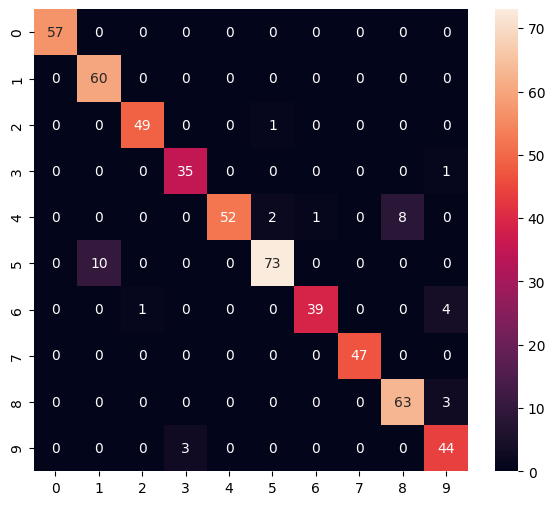

Classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        57
           1       0.86      1.00      0.92        60
           2       0.98      0.98      0.98        50
           3       0.92      0.97      0.95        36
           4       1.00      0.83      0.90        63
           5       0.96      0.88      0.92        83
           6       0.97      0.89      0.93        44
           7       1.00      1.00      1.00        47
           8       0.89      0.95      0.92        66
           9       0.85      0.94      0.89        47

    accuracy                           0.94       553
   macro avg       0.94      0.94      0.94       553
weighted avg       0.94      0.94      0.94       553



In [81]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

def print_confusion_matrix(y_true, y_pred, report=True):
    labels = sorted(list(set(y_true)))
    cmx_data = confusion_matrix(y_true, y_pred, labels=labels)
    
    df_cmx = pd.DataFrame(cmx_data, index=labels, columns=labels)
 
    fig, ax = plt.subplots(figsize=(7, 6))
    sns.heatmap(df_cmx, annot=True, fmt='g' ,square=False)
    ax.set_ylim(len(set(y_true)), 0)
    plt.show()
    
    if report:
        print('Classification Report')
        print(classification_report(y_test, y_pred))

Y_pred = model.predict(X_test)
y_pred = np.argmax(Y_pred, axis=1)

print_confusion_matrix(y_test, y_pred)

# Tensorflow-Lite用のモデルへ変換

In [82]:
# 推論専用のモデルとして保存
model.save(model_save_path, include_optimizer=False)

In [83]:
# モデルを変換(量子化)
tflite_save_path = 'model/keypoint_classifier/keypoint_classifier.tflite'

converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_quantized_model = converter.convert()

open(tflite_save_path, 'wb').write(tflite_quantized_model)

INFO:tensorflow:Assets written to: /var/folders/r9/kp6f96ks2llbn3n9bvxr_7c00000gn/T/tmp90mac35l/assets


INFO:tensorflow:Assets written to: /var/folders/r9/kp6f96ks2llbn3n9bvxr_7c00000gn/T/tmp90mac35l/assets
2022-11-30 13:58:52.917270: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-30 13:58:52.917294: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-30 13:58:52.917504: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /var/folders/r9/kp6f96ks2llbn3n9bvxr_7c00000gn/T/tmp90mac35l
2022-11-30 13:58:52.920136: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-30 13:58:52.920162: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /var/folders/r9/kp6f96ks2llbn3n9bvxr_7c00000gn/T/tmp90mac35l
2022-11-30 13:58:52.930572: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-30 13:58:53.005664: I tensorflow/cc/saved_model/loader.cc:213] Running initialization

6860

# 推論テスト

In [84]:
interpreter = tf.lite.Interpreter(model_path=tflite_save_path)
interpreter.allocate_tensors()

In [85]:
# 入出力テンソルを取得
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

In [86]:
interpreter.set_tensor(input_details[0]['index'], np.array([X_test[0]]))

In [87]:
%%time
# 推論実施
interpreter.invoke()
tflite_results = interpreter.get_tensor(output_details[0]['index'])

CPU times: user 47 µs, sys: 8 µs, total: 55 µs
Wall time: 60.8 µs


In [88]:
print(np.squeeze(tflite_results))
print(np.argmax(np.squeeze(tflite_results)))

[2.02594455e-02 4.40426320e-02 3.57844052e-03 1.98666640e-02
 7.82215446e-02 1.08458795e-01 2.08181969e-04 5.97797271e-06
 7.24416256e-01 9.42047918e-04]
8
